# 2D Toy Example

This Jupyter notebook provides the necessary Python code to reproduce the results of the 2D toy example discussed in Section 4.1 in the article:

Pascal Fernsel, Željko Kereta, Alexander Denker, *Convergence Properties of Score-Based Models for Linear Inverse Problems Using Graduated Optimisation*, 2024 IEEE International Workshop on Machine Learning for Signal Processing, September 22-25, 2024, London, UK


As described in the article, we consider a two dimensional inverse problem with forward operator $\mathbf{A} = \begin{pmatrix}
    1 & 1 \\ 
    0 & 0
\end{pmatrix}$ and clean measurements $\mathbf{y} = (2, 0)^\intercal.$ As a prior, we consider a Gaussian mixture model whose score can be computed analytically. The density at time step $t$ is a Gaussian mixture model with a perturbed covariance matrix $\Sigma_k^t = \Sigma_k + \frac{\sigma^{2t} -1}{2 \log \sigma} \mathbf{I}$. The diffusion process is given by the forward SDE $d\mathbf{x}_t = \sigma^t d \mathbf{w}_t$ with perturbation kernel $p_{t|0}(\mathbf{x}_t|\mathbf{x}_0)= \mathcal{N}(\mathbf{x}_t | \mathbf{x}_0, \frac{\sigma^{2t} -1}{2 \log \sigma} \mathbf{I})$.

We choose a constant regularisation parameter $\alpha_t = 5$ and adjust one mean of the Gaussian mixture model to the position $\mathbf{x}^* = (1, 1)^\intercal$ in order to ensure that the global minimum of the cost function $f$ with $t_\text{min}=10^{-3}$ is at $\mathbf{x}^*$.

We evaluate the graduated non-convexity flow (Algorithm 1) with a constant step size $\lambda_i = 1$ as well as the gradient-like method (Algorithm 2) with the adaptive smoothing schedule. The values $t_i$ are evenly spaced between $t_\text{min}$ and $t_\text{max}.$

The goal is to analyse the algorithms in terms of their convergence properties with respect to the initialisations $\mathbf{x}_1,$ the initial smoothing parameter $t_\text{max}$ and the iteration number. To do so, we run the algorithms with 1300 iterations for $10^{4}$ equally spaced initial points $\mathbf{x}_1$ on $[-10, 10]^2$ as well as 100 different values of $t_\text{max}\in [10^{-2}, 10]$, which are evenly distributed on a log scale. This results in a tensor with size [100, 10000, 1301, 2], which will be stored as an instance attribute of the class `Experiments2DIP`.

In the following, we shortly describe the provided Python files:

- `gaussian_mixture_model.py`: Defines the class `GaussianMixtureModel`, which contains all relevant information of the considered prior given by a Gaussian mixture model.
- `inverse_problem.py`: Defines the class `InverseProblem`, which contains all the relevant information of the considered inverse problem including the forward operator, the true solution and the prior in form of a `GaussianMixtureModel`.
- `experiments.py`: Defines the class `Experiments2DIP`, which contains the information of the numerical experiment including the inverse problem (in form of `InverseProblem`), the smoothing schedule as well as methods to plot the results.
- `optimizers.py`: Defines the classes `GradNonConvFlow` and `GradientLike`, which are subclasses `Experiments2DIP`. They contain additional information of the considered optimizer
    - `GradNonConvFlow`: Graduated Non-convexity Flow (see Algorithm 1 in the article)
    - `GradientLike`: Gradient Like Algorithm (see Algorithm 2 in the article)

## Graduated Non-convexity Flow
### Perform Experiment and Store the Iterates for all Hyperparameters 

In [ ]:
from inverse_problem import InverseProblem
from gaussian_mixture_model import GaussianMixtureModel
from optimizers import GradNonConvFlow
import torch
import numpy as np
import pickle

# Define Hyperparameters of the prior (GMM)

torch.manual_seed(2)

n_dim = 2
n_components = 5

weights = torch.rand(n_components) 
weights = weights / weights

means = [((torch.rand(n_dim)*2)-1)*10 for i in range(n_components)]
means[0] = torch.tensor([1., 1.])

covs = [2*torch.rand(1) * torch.eye(n_dim) for i in range(n_components)]
covs[0]=0.1 * torch.eye(n_dim)

gmm = GaussianMixtureModel(n_dim=n_dim, n_components=n_components, weights=weights, means=means, covs=covs)

# Define the inverse problem along with the forward operator A
x_true = torch.tensor([1., 1.])
A = torch.tensor([[1.,1.],[0., 0.]])
y = torch.matmul(A, x_true)

alphas = torch.tensor([1e-2, 0.5e-1])
sigma = 10

IP = InverseProblem(A, x_true, gmm, alphas, sigma)

xx, yy = np.meshgrid(np.linspace(-10,10, 100), np.linspace(-10,10, 100))
x_initial_grid = np.stack([xx.ravel(), yy.ravel()])

t_initial_points = np.logspace(np.log10(10),np.log10(1e-2), 100)

step_size = 1.
tmin = 1e-3
flag_smoothing_schedule_lin = True

exp = GradNonConvFlow(step_size, **{'IP': IP, 'x_initial_grid': x_initial_grid, 't_initial_points': t_initial_points, 'tmin': tmin, 'flag_smoothing_schedule_lin': flag_smoothing_schedule_lin})

exp.run()

# Pickle the object
with open('exp_gradNonConvFlow.pkl', 'wb') as file:
    pickle.dump(exp, file)

### Compute and Store the Plots
#### Load the Experiment Saved Above:

In [ ]:
from inverse_problem import InverseProblem
from gaussian_mixture_model import GaussianMixtureModel
from optimizers import GradNonConvFlow
import torch
import numpy as np
import pickle

# Unpickling the object
with open('exp_gradNonConvFlow.pkl', 'rb') as file:
    exp = pickle.load(file)

#### Rate of Trajectories converging to the Global Minimum Depending on the Iteration Number and $t_\text{max}$

In [3]:
path = "plots/gradNonConvFlow_convRate_globalMin.pt"
known_global_min = exp.IP.get_global_minimum(exp.tmin)
print(known_global_min)
exp.saveTensor_convRate_globalMin(path, 0.1, known_global_min)

tensor([1., 1.], dtype=torch.float64)


#### Rate of Trajectories converging to Stationary Points Depending on the Iteration Number and $t_\text{max}$

In [4]:
path = "plots/gradNonConvFlow_convRate_statPoints.pt"
exp.saveTensor_convRate_statPoints(path, 0.1)

### Plot the Results
#### Rate of trajectories (for different choices of $t_\text{max}$) converging to the global minimum depending on the initial starting point

tensor([1., 1.], dtype=torch.float64)


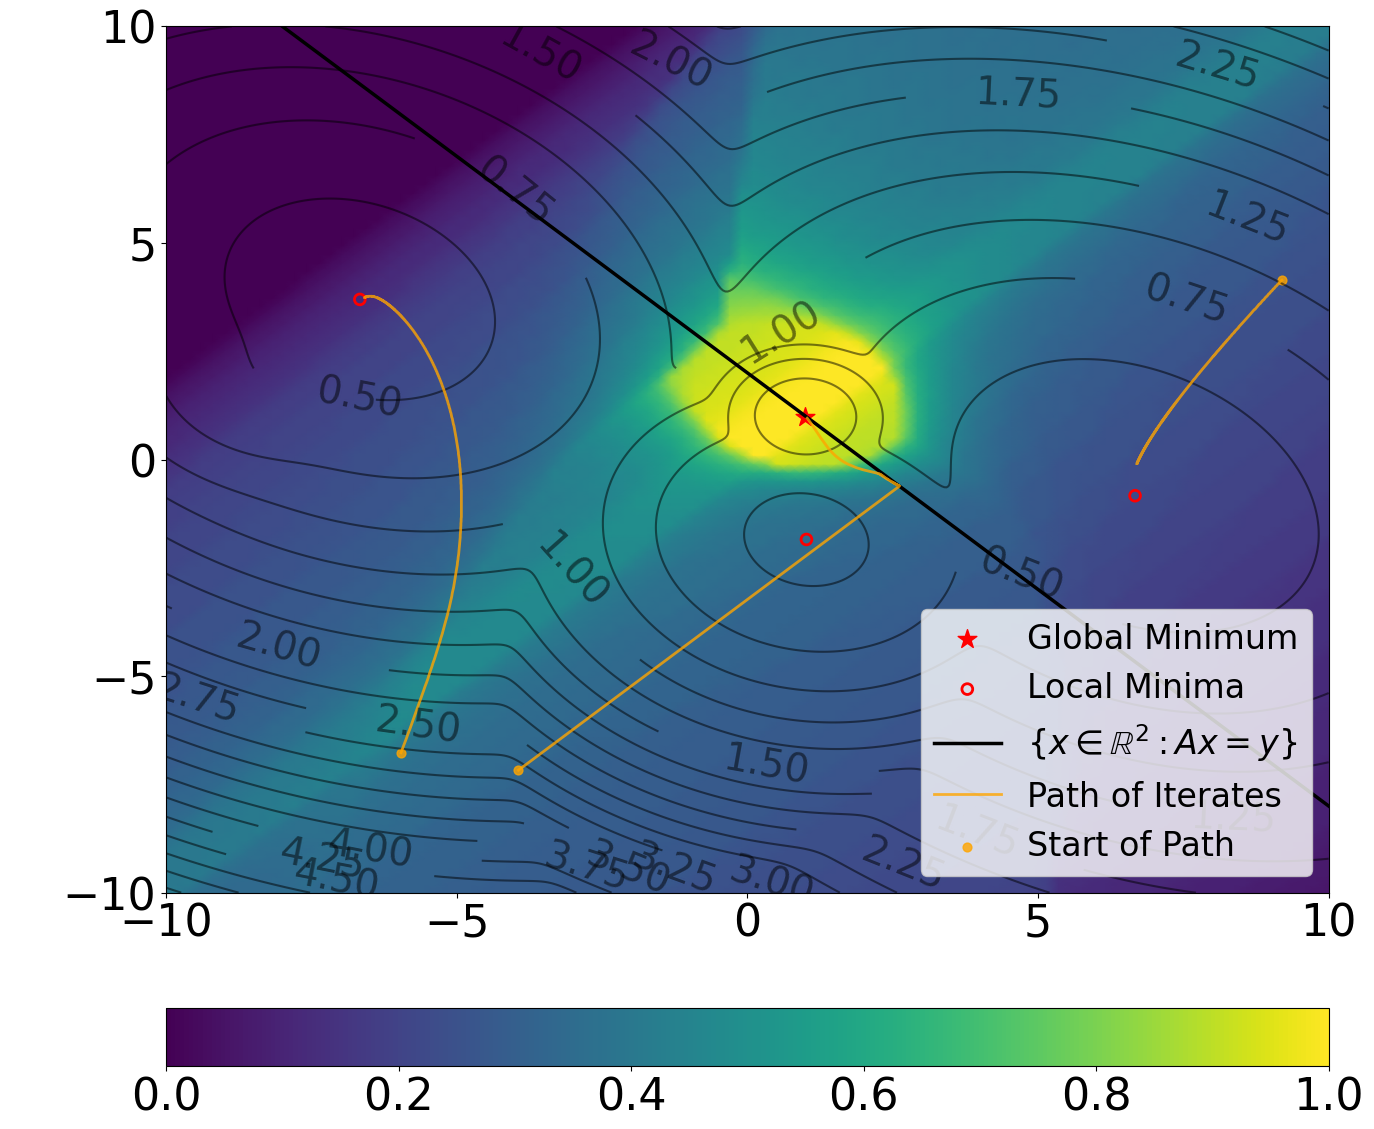

(<Figure size 1500x1500 with 2 Axes>, <Axes: ylabel=' '>)

In [2]:
xy_min_max = np.array([-10, 10])
# known_global_min = torch.tensor([1., 1.])
known_global_min = exp.IP.get_global_minimum(exp.tmin)
print(known_global_min)

handpicked_localmin = [2, 12, -6]

stationary_points = exp.get_stationary_points(8e-4, np.array([-10, 10]), False)

path_iterates = exp.history_tensor[[15, 50, 70],[1430, 1620, 7095],:,:]

path = "plots/gradNonConvFlow_convRate_gmin_xyPlane.png"
exp.plot_convRate_globalMin_xyPlane(path, 0.1, known_global_min, xy_min_max, stationary_points[:, handpicked_localmin], path_iterates)

#### Rate of trajectories (for different initial starting points) converging to the global minimum depending on the iteration number and $t_\text{max}$

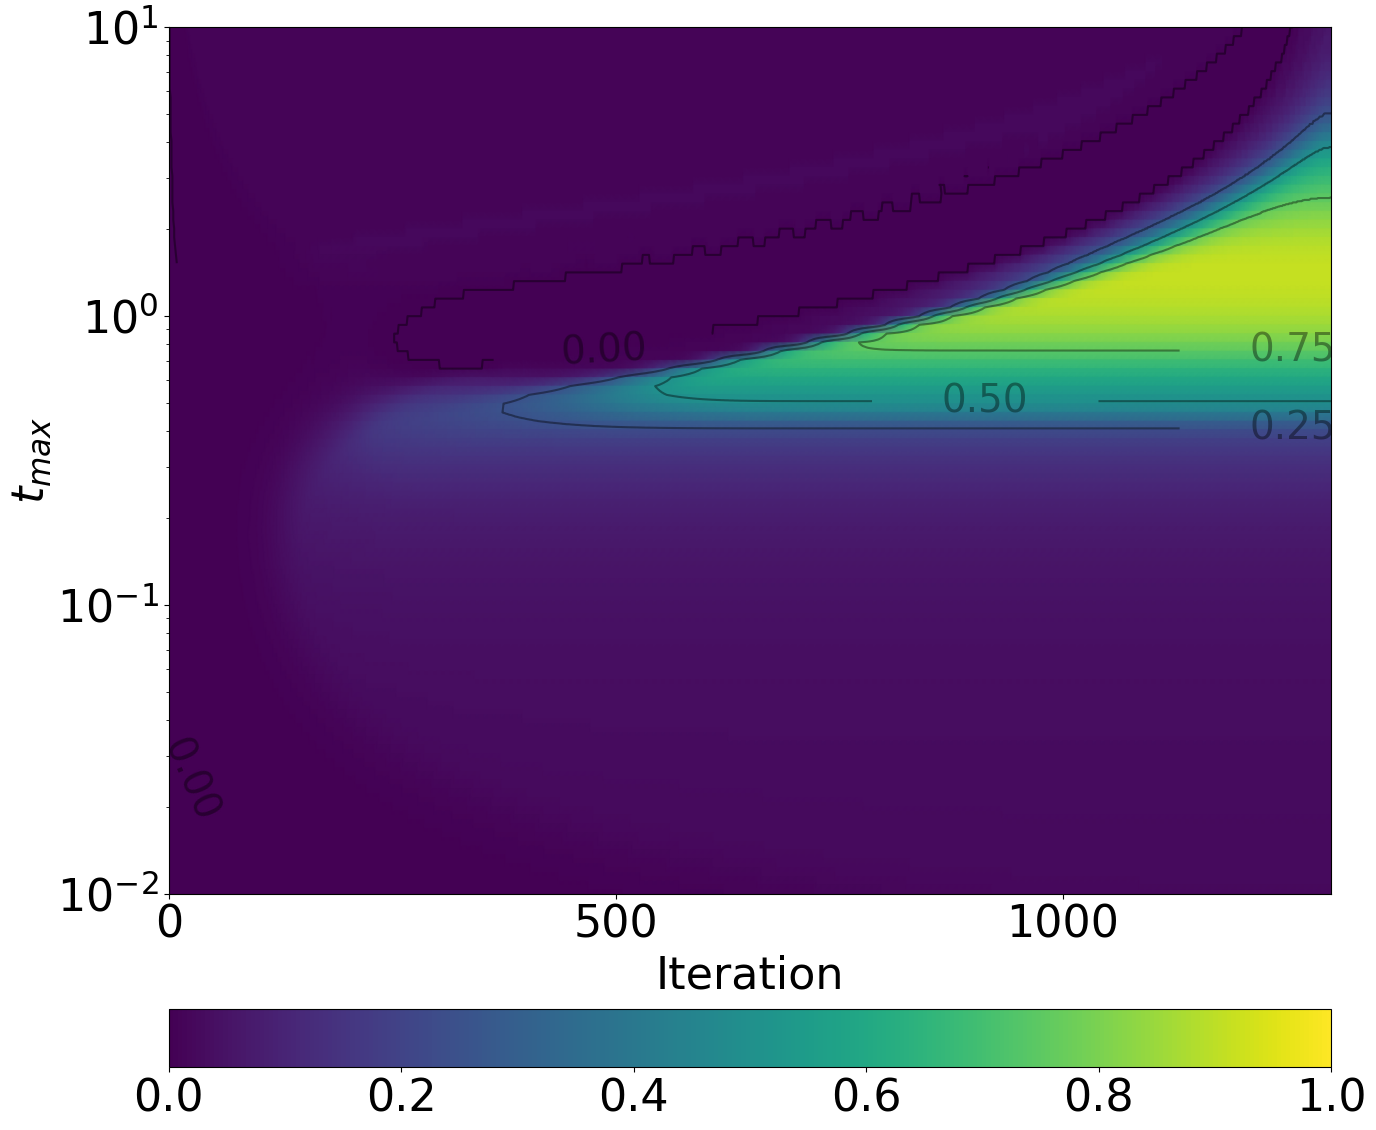

In [3]:
gradNonConvFlow_convRate_globalMin = torch.load('plots/gradNonConvFlow_convRate_globalMin.pt')
path = "plots/gradNonConvFlow_convRate_globalMin.png"
vminmax = [0, 1]
# vminmax = [None, None]
exp.plot_convRate_globalMin(path, gradNonConvFlow_convRate_globalMin, vminmax)

#### Rate of trajectories (for different initial starting points) converging to stationary points depending on the iteration number and $t_\text{max}$

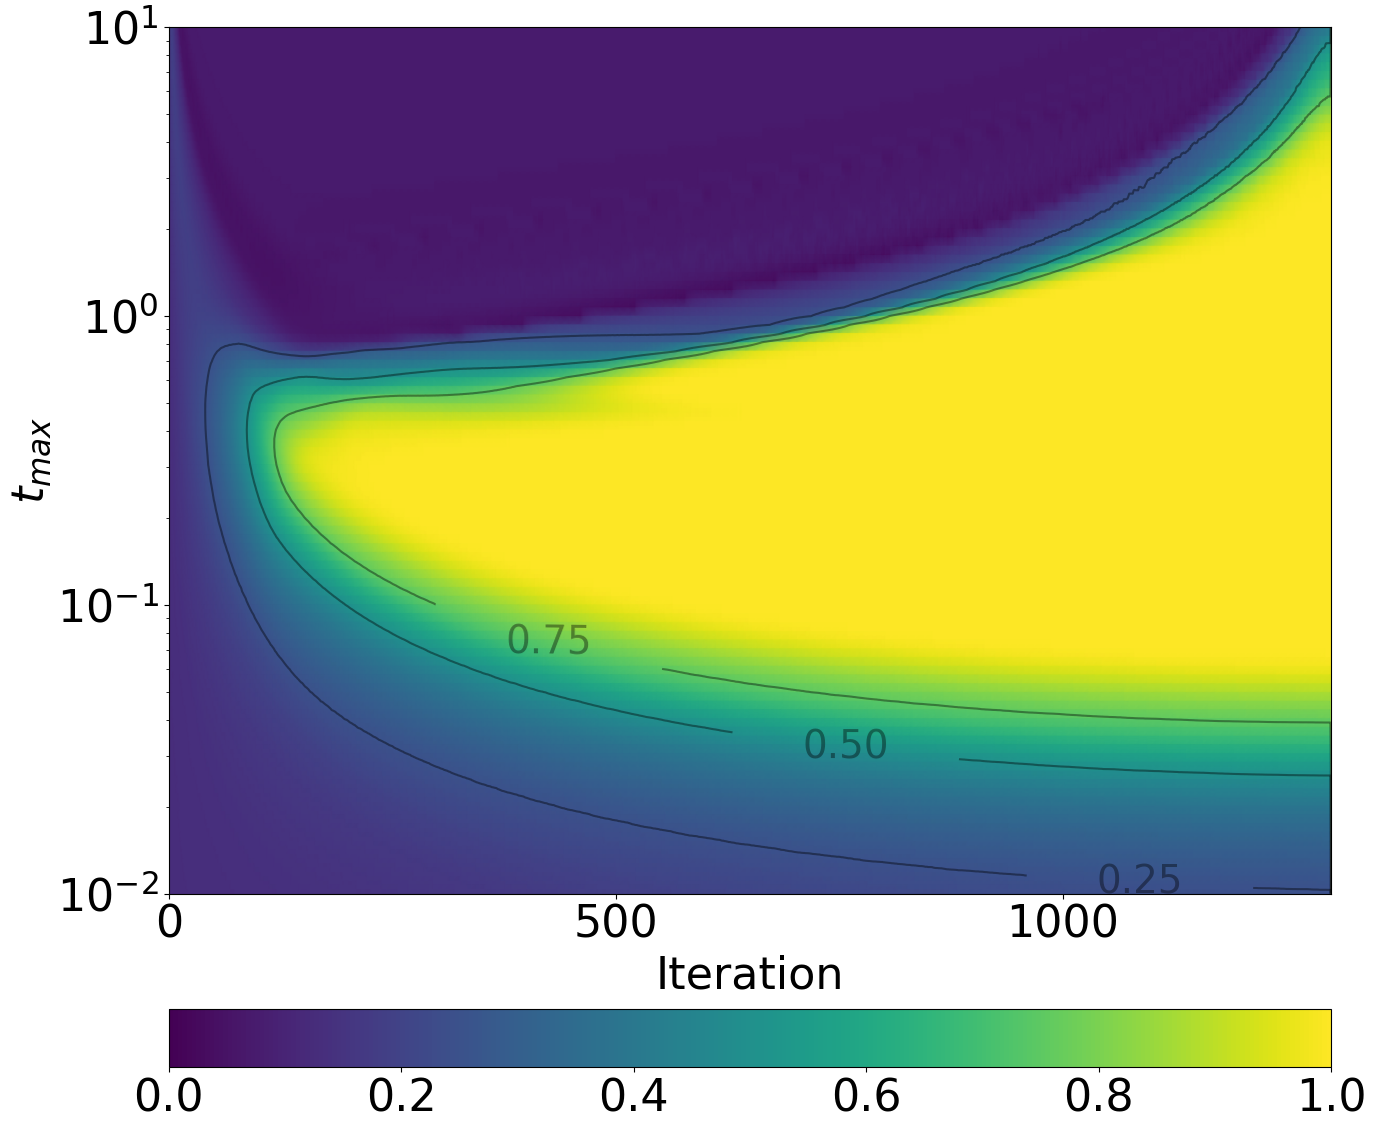

In [4]:
gradNonConvFlow_convRate_statPoints = torch.load('plots/gradNonConvFlow_convRate_statPoints.pt')
path = "plots/gradNonConvFlow_convRate_statPoints.png"
vminmax = [0, 1]
# vminmax = [None, None]
exp.plot_convRate_statPoints(path, gradNonConvFlow_convRate_statPoints, vminmax)

## Gradient Like Algorithm
### Perform Experiment and Store the Iterates for all Hyperparameters 

In [ ]:
from inverse_problem import InverseProblem
from gaussian_mixture_model import GaussianMixtureModel, diffuse_gmm
# from experiments import ExperimentsSBMConv2D
from optimizers import GradientLike
import torch
import numpy as np
import pickle

# Define Hyperparameters of the prior (GMM)

torch.manual_seed(2)

n_dim = 2
n_components = 5

weights = torch.rand(n_components) 
weights = weights / weights

means = [((torch.rand(n_dim)*2)-1)*10 for i in range(n_components)]
means[0] = torch.tensor([1., 1.])

covs = [2*torch.rand(1) * torch.eye(n_dim) for i in range(n_components)]
covs[0]=0.1 * torch.eye(n_dim)

gmm = GaussianMixtureModel(n_dim=n_dim, n_components=n_components, weights=weights, means=means, covs=covs)

# Define the inverse problem along with the forward operator A
x_true = torch.tensor([1., 1.])
A = torch.tensor([[1.,1.],[0., 0.]])
y = torch.matmul(A, x_true)

alphas = torch.tensor([1e-2, 0.5e-1])
sigma = 10

IP = InverseProblem(A, x_true, gmm, alphas, sigma)

xx, yy = np.meshgrid(np.linspace(-10,10, 100), np.linspace(-10,10, 100))
x_initial_grid = np.stack([xx.ravel(), yy.ravel()])

# x_initial_grid = np.array([[-10., 4., 2.], [10., -3., 1.]])
# x_initial_grid = np.array([[-8., 7., -5., 0., 9., 4.], [7., -2., -7., 3., -6., 8.]])
# x_initial_grid = np.array([[4.], [-3. ]])
# t_initial_points = np.array([10., 0.5])
# t_initial_points = np.array([8., 1])
# t_initial_points = np.array([0.5])
t_initial_points = np.logspace(np.log10(10),np.log10(1e-2), 100)

# step_size = 1.
tmin = 1e-3
flag_smoothing_schedule_lin = True

exp = GradientLike(**{'IP': IP, 'x_initial_grid': x_initial_grid, 't_initial_points': t_initial_points, 'tmin': tmin, 'flag_smoothing_schedule_lin': flag_smoothing_schedule_lin})

exp.run()

# Pickle the object
with open('exp_gradientLike.pkl', 'wb') as file:
    pickle.dump(exp, file)

### Compute and Store the Plots
#### Load the Experiment Saved Above:

In [1]:
from inverse_problem import InverseProblem
from gaussian_mixture_model import GaussianMixtureModel
from optimizers import GradNonConvFlow
import torch
import numpy as np
import pickle

# Unpickling the object
with open('exp_gradientLike.pkl', 'rb') as file:
    exp = pickle.load(file)

#### Rate of Trajectories converging to the Global Minimum Depending on the Iteration Number and $t_\text{max}$

In [3]:
path = "plots/gradientLike_convRate_globalMin.pt"
known_global_min = exp.IP.get_global_minimum(exp.tmin)
print(known_global_min)
exp.saveTensor_convRate_globalMin(path, 0.1, known_global_min)

tensor([1., 1.], dtype=torch.float64)


#### Rate of Trajectories converging to Stationary Points Depending on the Iteration Number and $t_\text{max}$

In [4]:
path = "plots/gradientLike_convRate_statPoints.pt"
exp.saveTensor_convRate_statPoints(path, 0.1)

### Plot the Results
#### Rate of trajectories (for different choices of $t_\text{max}$) converging to the global minimum depending on the initial starting point

tensor([1., 1.], dtype=torch.float64)


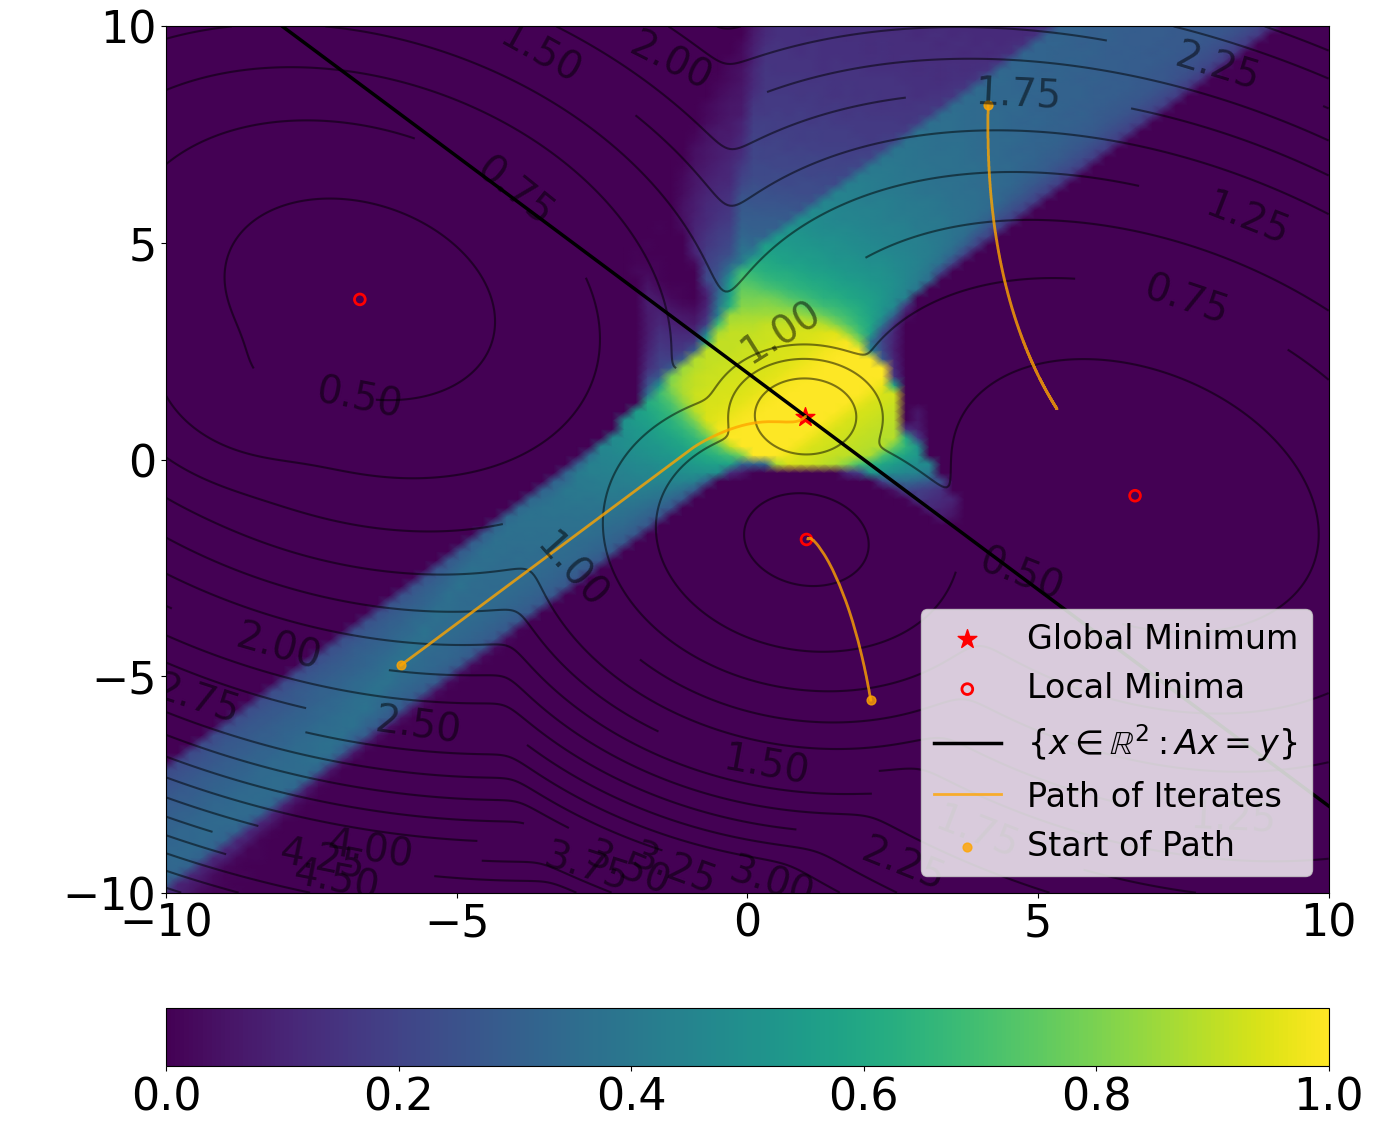

(<Figure size 1500x1500 with 2 Axes>, <Axes: ylabel=' '>)

In [2]:
xy_min_max = np.array([-10, 10])
# known_global_min = torch.tensor([1., 1.])
known_global_min = exp.IP.get_global_minimum(exp.tmin)
print(known_global_min)

handpicked_localmin = [2, 12, -6]

stationary_points = exp.get_stationary_points(8e-4, np.array([-10, 10]), False)

path_iterates = exp.history_tensor[[15, 70, 60],[2620, 9070, 2260],:,:]

path = "plots/gradientLike_convRate_gmin_xyPlane.png"
exp.plot_convRate_globalMin_xyPlane(path, 0.1, known_global_min, xy_min_max, stationary_points[:, handpicked_localmin], path_iterates)

#### Rate of trajectories (for different initial starting points) converging to the global minimum depending on the iteration number and $t_\text{max}$

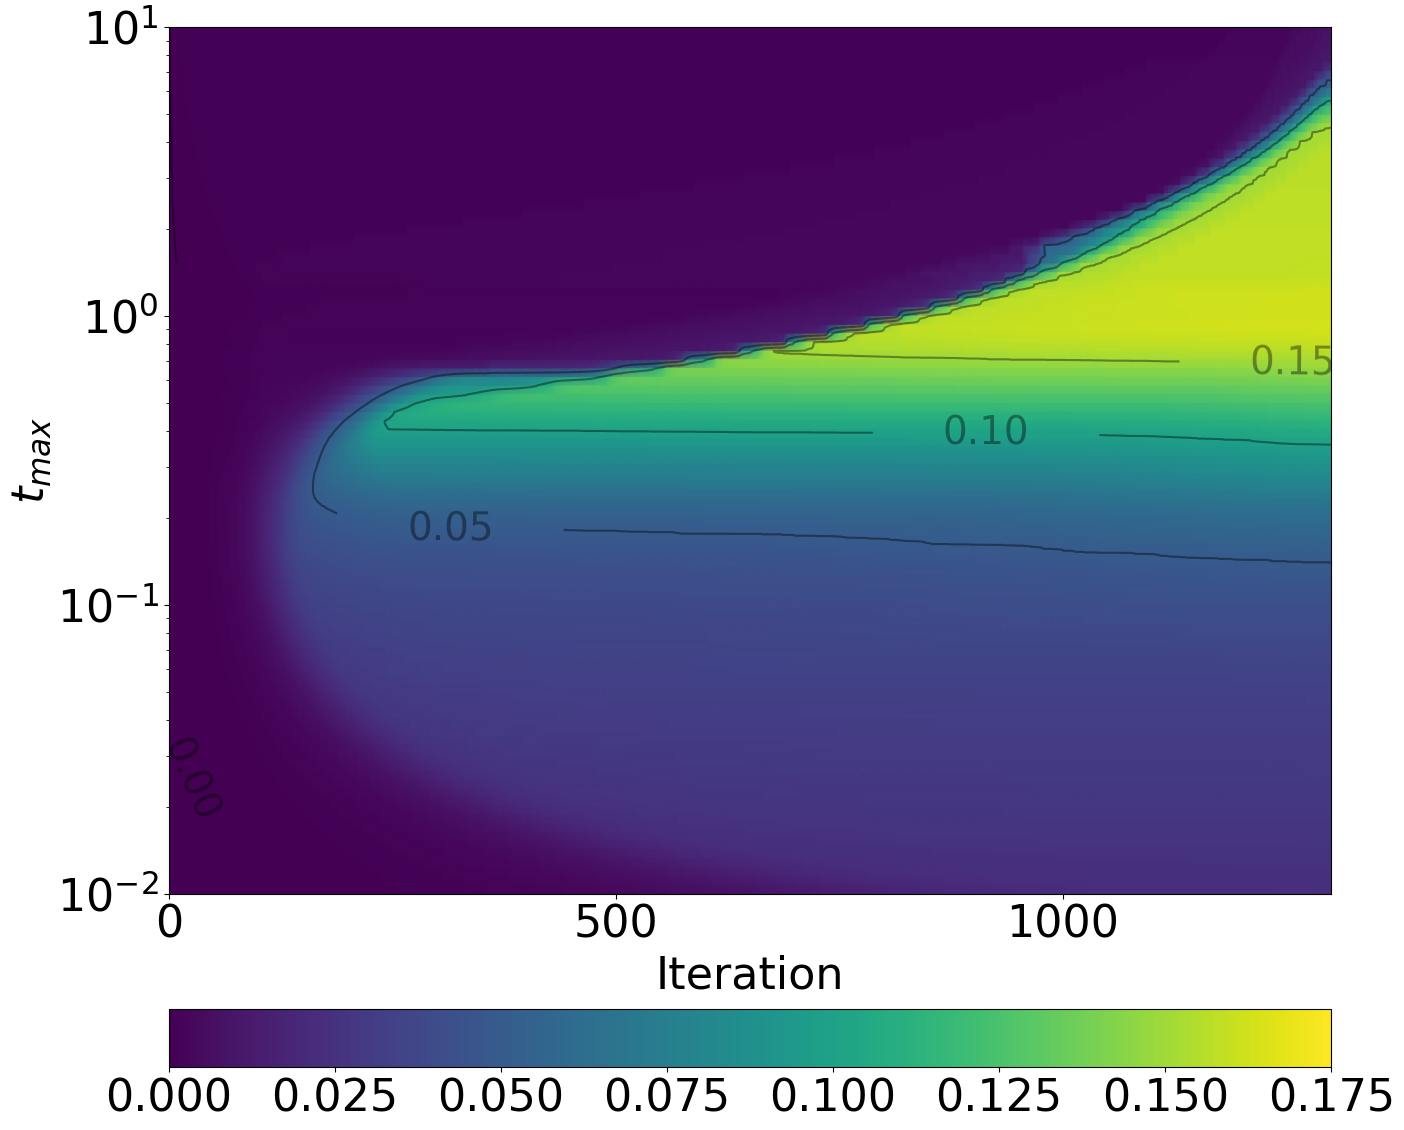

In [3]:
gradNonConvFlow_convRate_globalMin = torch.load('plots/gradientLike_convRate_globalMin.pt')
path = "plots/gradientLike_convRate_globalMin.png"
# vminmax = [0, 1]
vminmax = [0, 0.175]
exp.plot_convRate_globalMin(path, gradNonConvFlow_convRate_globalMin, vminmax)

#### Rate of trajectories (for different initial starting points) converging to stationary points depending on the iteration number and $t_\text{max}$

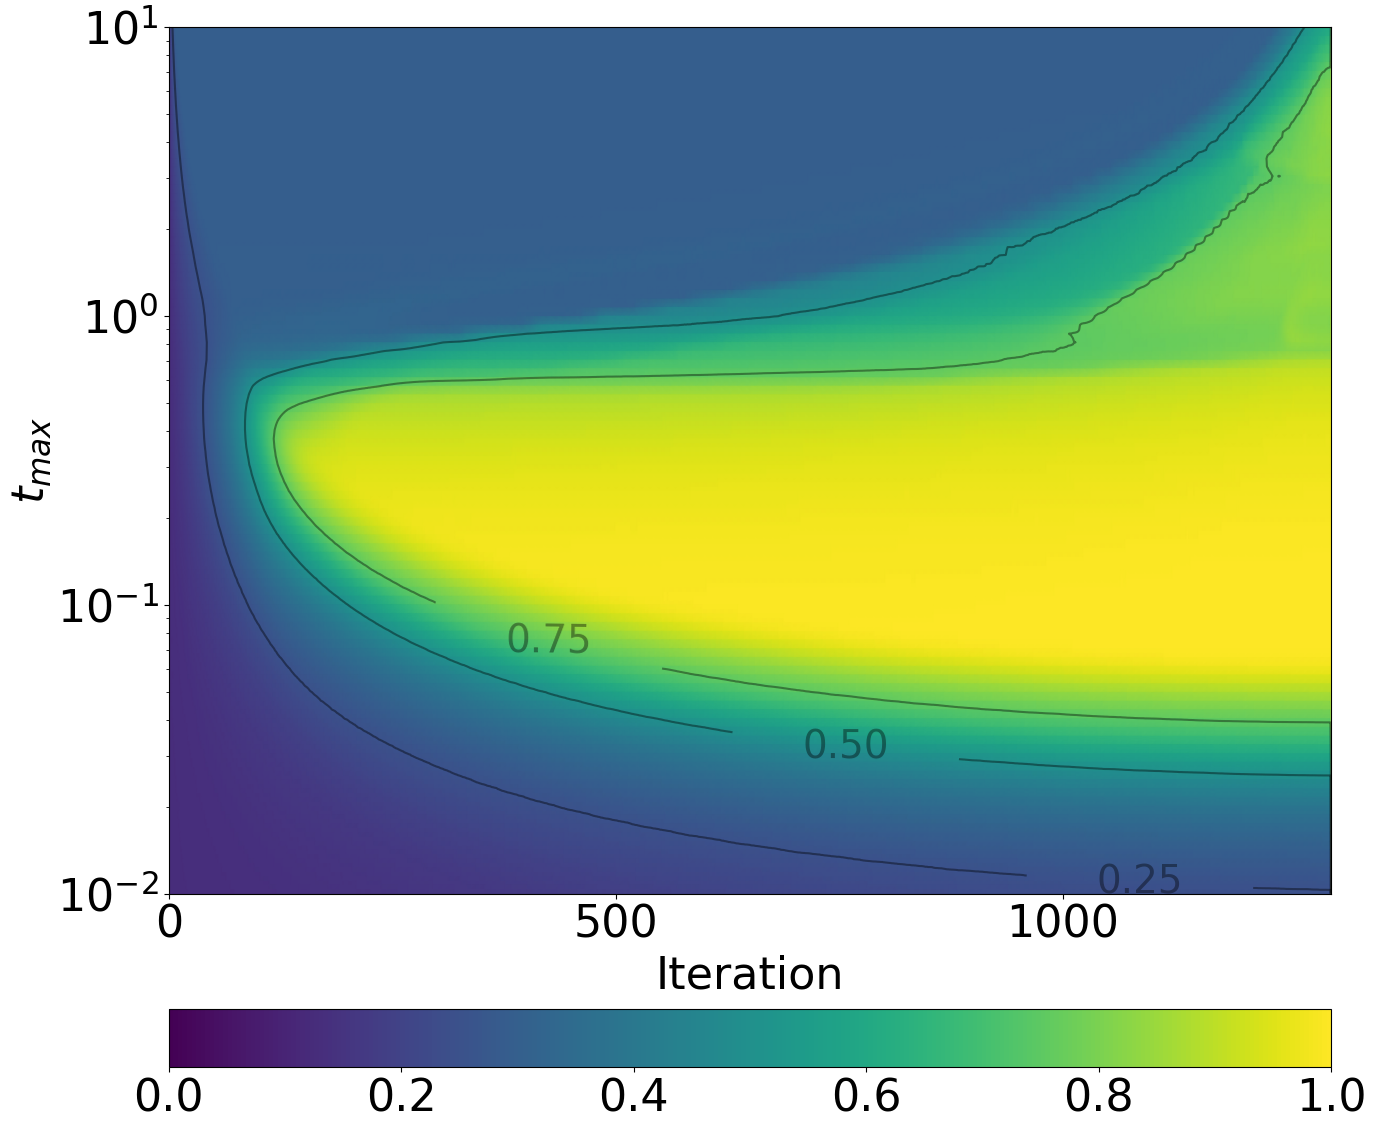

In [4]:
gradNonConvFlow_convRate_statPoints = torch.load('plots/gradientLike_convRate_statPoints.pt')
path = "plots/gradientLike_convRate_statPoints.png"
vminmax = [0, 1]
# vminmax = [None, None]
exp.plot_convRate_statPoints(path, gradNonConvFlow_convRate_statPoints, vminmax)